# Crypto Kitties Explorer

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_colwidth', 70)

In [2]:
events = pd.read_pickle('ck-data/events_4605167-to-5374870.pickle.gz')

In [3]:
print('Block range: ' + str(events.blockNumber_dec.min()) + ' to ' + str(events.blockNumber_dec.max()))

Block range: 4605167 to 5374870


In [4]:
events.groupby(['contract','event']).transactionHash.count()

contract       event            
core           Approval                 506
               Birth                 663289
               Pregnant              649569
               Transfer             2034114
saleAuction    AuctionCancelled      111097
               AuctionCreated        587803
               AuctionSuccessful     338449
siringAuction  AuctionCancelled       43771
               AuctionCreated        159738
               AuctionSuccessful      76698
Name: transactionHash, dtype: int64

^ As expected, the core game smart-contract is reponsible for logging the births, pregnancies, transfers and approvals of kitties. The auctioning smart-contracts log events referring to creation, completion and cancellation of auctions.

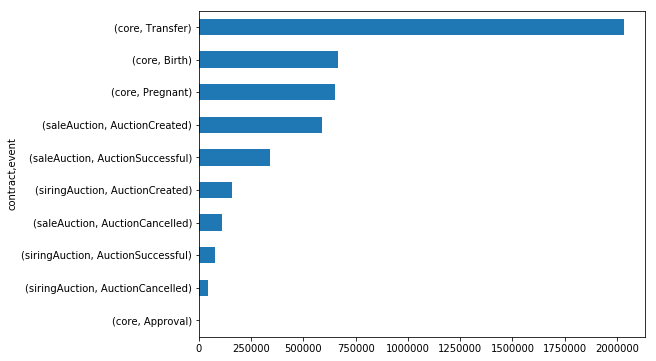

In [5]:
event_counts = events.groupby(['contract','event']).transactionHash.count()
event_counts.sort_values().plot(kind='barh', figsize=(8, 6))

In [6]:
event_counts_df = event_counts.reset_index()
event_counts_df.columns = ['contract', 'event', 'count']
event_counts_df

,contract,event,count
0,core,Approval,506
1,core,Birth,663289
2,core,Pregnant,649569
3,core,Transfer,2034114
4,saleAuction,AuctionCancelled,111097
5,saleAuction,AuctionCreated,587803
6,saleAuction,AuctionSuccessful,338449
7,siringAuction,AuctionCancelled,43771
8,siringAuction,AuctionCreated,159738
9,siringAuction,AuctionSuccessful,76698


In [7]:
transfer_count = event_counts_df[event_counts_df['event']=='Transfer'].iloc[0]['count']

sale_auction_cancelled_count = event_counts_df[(event_counts_df['event']=='AuctionCancelled') & \
                                             (event_counts_df['contract']=='saleAuction')].iloc[0]['count']

siring_auction_cancelled_count = event_counts_df[(event_counts_df['event']=='AuctionCancelled') & \
                                             (event_counts_df['contract']=='siringAuction')].iloc[0]['count']

sale_auction_created_count = event_counts_df[(event_counts_df['event']=='AuctionCreated') & \
                                             (event_counts_df['contract']=='saleAuction')].iloc[0]['count']

siring_auction_created_count = event_counts_df[(event_counts_df['event']=='AuctionCreated') & \
                                             (event_counts_df['contract']=='siringAuction')].iloc[0]['count']

sale_auction_successful_count = event_counts_df[(event_counts_df['event']=='AuctionSuccessful') & \
                                             (event_counts_df['contract']=='saleAuction')].iloc[0]['count']

siring_auction_successful_count = event_counts_df[(event_counts_df['event']=='AuctionSuccessful') & \
                                             (event_counts_df['contract']=='siringAuction')].iloc[0]['count']

birth_count = event_counts_df[(event_counts_df['event']=='Birth')].iloc[0]['count']

pregnant_count = event_counts_df[(event_counts_df['event']=='Pregnant')].iloc[0]['count']

In [8]:
(transfer_count - \
sale_auction_cancelled_count - \
siring_auction_cancelled_count - \
sale_auction_created_count - \
siring_auction_created_count - \
sale_auction_successful_count - \
birth_count ) / \
transfer_count

0.063893665743414582

^ Only 0.6% of transfers happen outside of the context of game auction smart-contracts

In [9]:
pregnant_count/siring_auction_successful_count

8.4691778142845973

^ The Pregnant event is a lot more frequent than the AuctionSuccessful event by the siring auction smart-contract. Bcause every successful siring auction results in a pregancy, this means that most breeding is being done between cats that belong to the same player.

In [10]:
events['contract-event'] = events['contract'] + events['event']
events['block-group'] = events['blockNumber_dec'].apply(lambda x: int(x/1000))

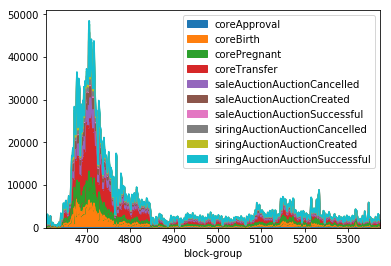

In [11]:
areaplot = events.groupby(['block-group','contract-event']).transactionHash.count().reset_index().pivot(index='block-group', columns='contract-event', values='transactionHash')#.plot.area()
areaplot.plot.area()
plt.legend(loc=1)

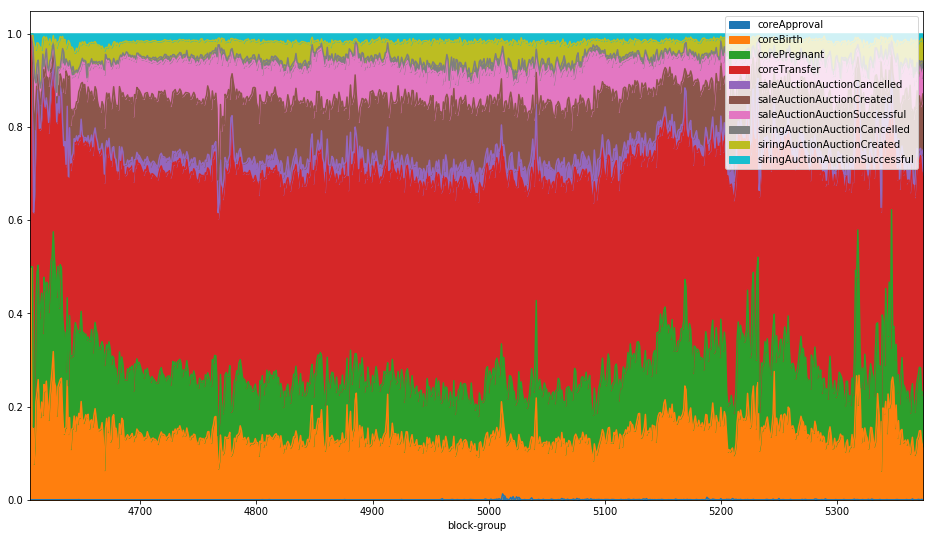

In [12]:
areaplot.divide(areaplot.sum(axis=1), axis=0).plot.area(figsize=(16, 9))
plt.legend(loc=1)

In [13]:
(events[events['event']=='Birth'])[['transactionHash','event']].groupby(['transactionHash']).count().head()

,event
transactionHash,
0x00000146c9713f7a13ef07fd6f17145d9adacb9f6a51a49eade85ea9165962de,1
0x00000203bfb7473c3898cd33ec694065cb8c2b911c93c17c42764d8a97a3f703,1
0x00001491cb7e109fcb9adb9341d9802675820ddd818b7ebd5ac96054502764ff,3
0x00001a5b846a9ccb4694db2653e6c91286c81414e3454ff5ad8e53ade8edc6d0,1
0x000022afe63a97f580250dccfb24a205258bb63641541c78e777cda4cc3dfb7f,2


Based on my understanding of the game dynamics, I expected every transaction to cause one event to happen, or at most two in case of a successful siring or sale auction, which would be followed by a pregnancy or a transfer.
But when we group the events by the transaction that caused them to happen, we see sometimes a single transaction causes more than one event to happen, eg 0x21e6760d4cb24918c1d0d2722674e2fae90acf64516b27cc233446909e6c1a6e

### Who is calling giveBirth?

Let's take a deeper look at the Birth events

In [14]:
births = pd.read_pickle('ck-data/births_4605167-to-5374870.pickle.gz')

In [15]:
births['owner'] = '0x' + births['data'].apply(lambda x: x[26:66])
births['kittyId'] = births['data'].apply(lambda x: x[66:130])
births['kittyId_dec'] = births['kittyId'].apply(lambda x: int(x,16))
births['matronId'] = births['data'].apply(lambda x: x[130:194])
births['matronId_dec'] = births['matronId'].apply(lambda x: int(x,16))
births['sireId'] = births['data'].apply(lambda x: x[194:258])
births['sireId_dec'] = births['sireId'].apply(lambda x: int(x,16))
births['kittyGenes'] = births['data'].apply(lambda x: x[258:322])
births['block-group'] = births['blockNumber_dec'].apply(lambda x: int(x/1000))

Most transactions only give birth to one cat; but some give birth to more

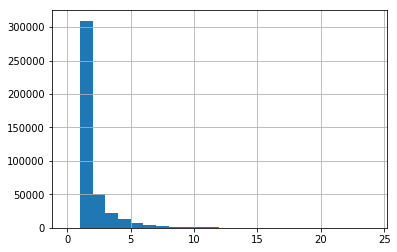

In [141]:
maxBirths = births.groupby(['transactionHash']).transactionHash.count().max()
births.groupby(['transactionHash']).transactionHash.count().hist(bins=range(maxBirths+2))

Who is making the transaction

In [17]:
births['midwife'] = births['transaction'].apply(lambda x: eval(x)['from'])

What smart-contract are they sending the transaction to

In [18]:
births['midwife_smartcontract'] = births['transaction'].apply(lambda x: eval(x)['to'])

How much are they paying for gas

In [19]:
births['gasPrice'] = births['transaction'].apply(lambda x: int(eval(x)['gasPrice'],16))

How much that means in fees

In [20]:
births['fee'] = births['gasUsed'] * births['gasPrice'] * 1E-18

In [21]:
AxiomZenAccounts = ['0xa21037849678af57f9865c6b9887f4e339f6377a','0xba52c75764d6f594735dc735be7f1830cdf58ddf']

A few accounts are responsible for most of the births

In [22]:
allTimeTopMidwives = births.groupby(['midwife']).data.count().\
                sort_values(ascending=False).head(10)
allTimeTopMidwives = set(allTimeTopMidwives.index.values)
allTimeTopMidwives

{'0x05be6e1f661dacd4630e1ebe2ffce5bfb962076f',
 '0x49c4460cc2366bd93d24974ff6813ef7ff4fb649',
 '0x6fc9bcb6091c01d6d2a530955e633b894ae48256',
 '0x85009f1044843353f836fda4a24d748460a30e77',
 '0x8ae8713ab277d954813ec6ddfb13f68d8cc1b109',
 '0xa21037849678af57f9865c6b9887f4e339f6377a',
 '0xb7f819b983e0cbb0316786d7fba12e3b1e58da5f',
 '0xc554ec868e5aaa288c11e7b75e74696a2a24c3dc',
 '0xc5b373618d4d01a38f822f56ca6d2ff5080cc4f2',
 '0xed9878336d5187949e4ca33359d2c47c846c9dd3'}

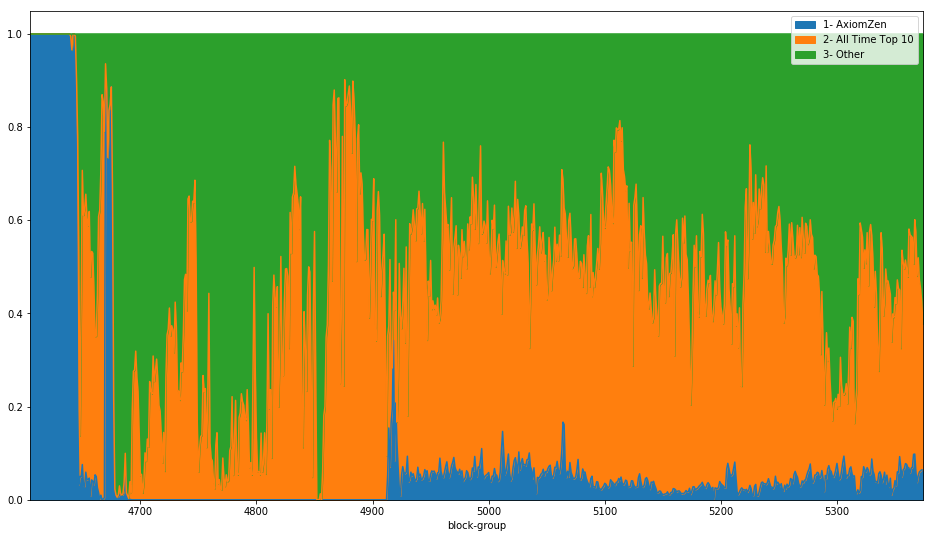

In [23]:
births['midwife-group'] = births['midwife'].apply(lambda x: '1- AxiomZen' \
                                                if x in AxiomZenAccounts \
                                                else '2- All Time Top 10' if x in allTimeTopMidwives \
                                                else '3- Other')
areaplot = births.groupby(['block-group','midwife-group']).transactionHash.count().reset_index().pivot(index='block-group', columns='midwife-group', values='transactionHash')
areaplot.divide(areaplot.sum(axis=1), axis=0).plot.area(figsize=(16, 9))
plt.legend(loc=1)

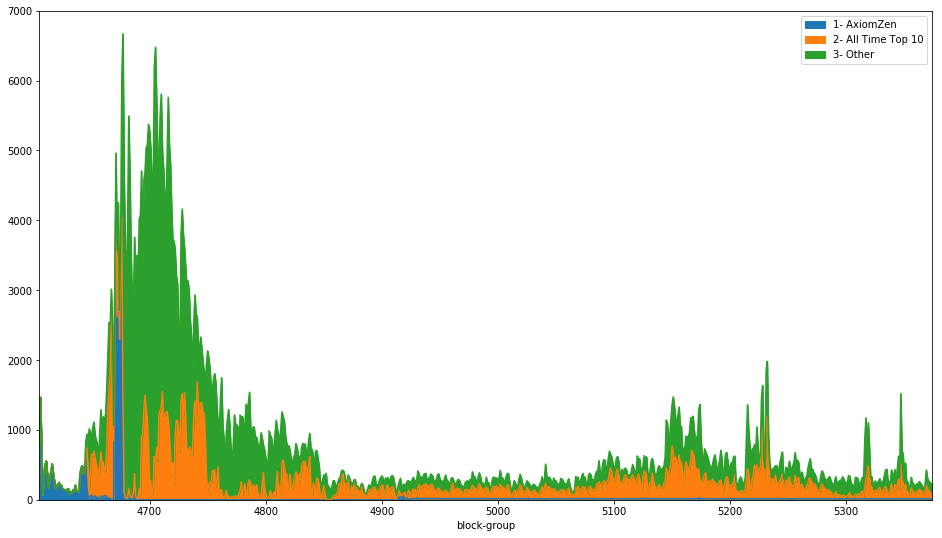

In [24]:
areaplot.plot.area(figsize=(16, 9))
plt.legend(loc=1)

In [25]:
movingTopFiveMidwives = births.groupby(['block-group','midwife']).data.count().reset_index().\
                sort_values(by=['block-group','data'],ascending=False).groupby(['block-group']).head(5)
movingTopFiveMidwives = set(movingTopFiveMidwives.midwife.values)

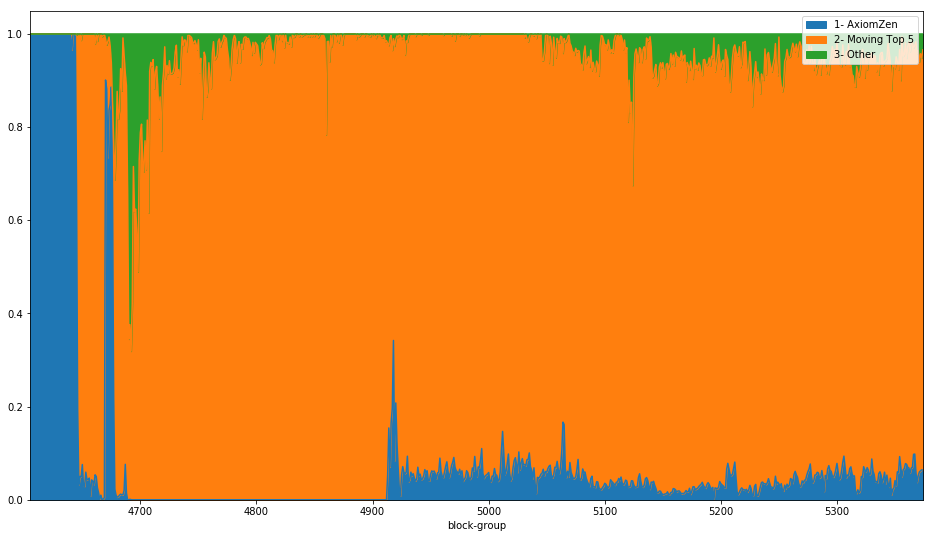

In [26]:
births['midwife-group'] = births['midwife'].apply(lambda x: '1- AxiomZen' \
                                                if x in AxiomZenAccounts \
                                                else '2- Moving Top 5' if x in movingTopFiveMidwives \
                                                else '3- Other')
areaplot = births.groupby(['block-group','midwife-group']).transactionHash.count().reset_index().pivot(index='block-group', columns='midwife-group', values='transactionHash')
areaplot.divide(areaplot.sum(axis=1), axis=0).plot.area(figsize=(16, 9))
plt.legend(loc=1)

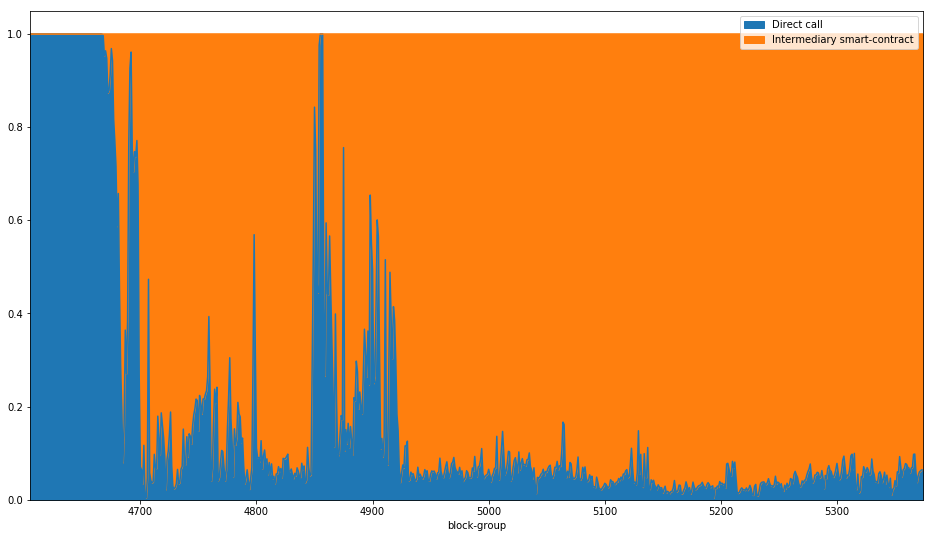

In [27]:
births['type-of-call'] = births['midwife_smartcontract'].apply(lambda x: 'Direct call' \
                                                if x == '0x06012c8cf97bead5deae237070f9587f8e7a266d' \
                                                else 'Intermediary smart-contract')
areaplot = births.groupby(['block-group','type-of-call']).transactionHash.count().reset_index().pivot(index='block-group', columns='type-of-call', values='transactionHash')
areaplot.divide(areaplot.sum(axis=1), axis=0).plot.area(figsize=(16, 9))
plt.legend(loc=1)

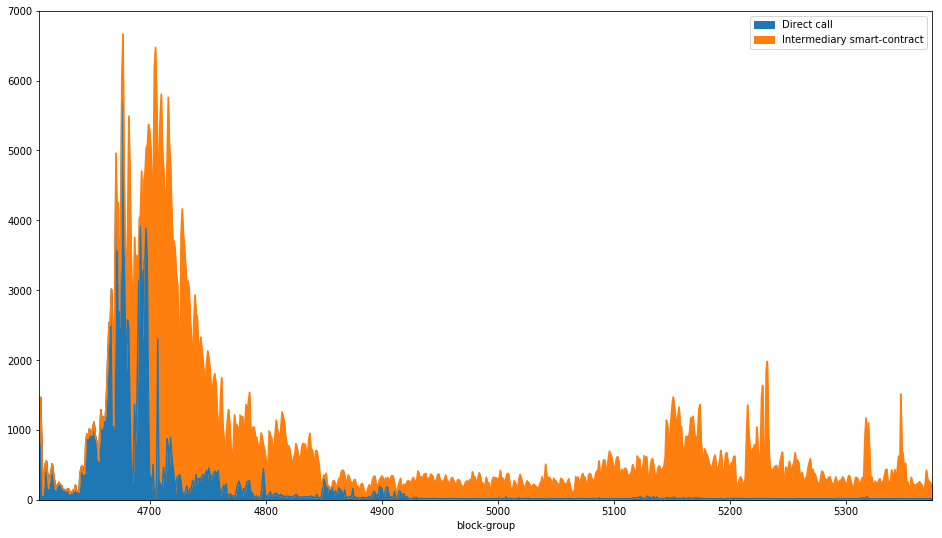

In [28]:
areaplot.plot.area(figsize=(16, 9))
plt.legend(loc=1)

And those accounts are not directly calling the giveBirth method on the core game smart-contract (0x06012...). Instead, they are sending transactions to other accounts. A quick look at those accounts on Etherscan shows us that those are smart-contracts. So people are calling intermediary smart-contracts that in turn call giveBirth on a series of pregnant kitties. There are less intermediary smart-contracts than accounts calling them, which leads us to believe that there are even less people doing this than the initial number of accounts would suggest (one person might be using several accounts to call their intermediary smart-contract, but there is not much point in a single person having several smart contracts)

Text(0.5,0,'kitties delivered')

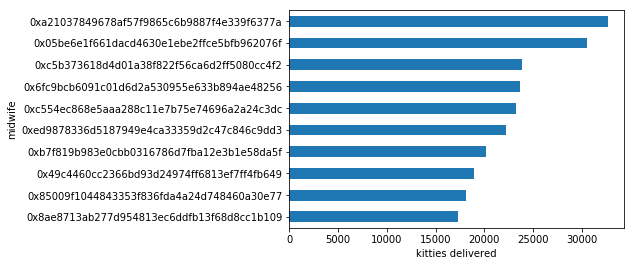

In [152]:
births[births['midwife'].isin(allTimeTopMidwives)].groupby(['midwife']).data.count().sort_values().plot(kind='barh')
plt.xlabel('kitties delivered')

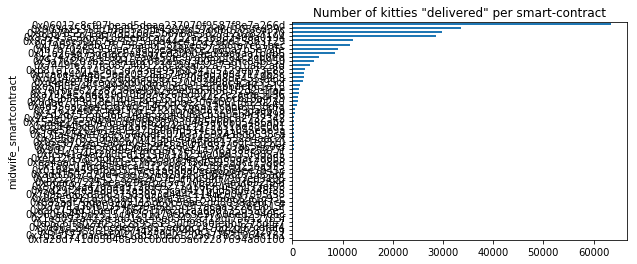

In [30]:
births[births['midwife'].isin(allTimeTopMidwives)].groupby(['midwife_smartcontract']).data.count().sort_values().plot(kind='barh', title='Number of kitties "delivered" per smart-contract')

When you breed two cats, you must provide a birthing fee (0.008 ETH as of now), to be collected by the account that calls the giveBirth method on the matron cat at or after the block when the pregnancy ends. *Anyone* can call that method and thus collect the fee, but the new cat always goes to the owner of the matron.

I did not see the reasoning behind this fee, as it seemed to only make the game more expensive to be played. The giveBirth method could have been integrated into some other action of the game in such a way that the player would naturally call it whenever givingBirth suited their needs. Then I found [this](https://medium.com/cryptokitties/cryptokitties-birthing-fees-increases-in-order-to-accommodate-demand-acc314fcadf5):
>Because this giveBirth() function includes a random element, it is critical that it is called quickly after the expected birthing time (within 250 blocks, or about 30 minutes). If the call takes any longer, it provides the opportunity for bad actors to “re-roll” the random element of their genetic combination and gain an unfair advantage against other breeders. To keep this from happening, we allow anyone to call giveBirth() and we give the entire birthing fee to the first midwife that successfully births the new kitten. This ensures that ... there is an incentive for other people in the community to ensure that all births are happening quickly.

So the game creates an incentive for people - who might not even be players of the game themselves - to call the giveBirth method on other people's pregnant cats. Sure enough, bots (smart-contracts) seem to have been coded to do just that.

In [31]:
#dataset of all transactions from midwife to midwife-smartcontract
#this includes transactions to the core game smart contract that are not calls to giveBirth, so we remove those
df_all_midwifing_txns = pd.read_pickle('ck-data/midwives-txns_4605167-to-5374870.pickle.gz')
#drop transactions to the core game that are not calls to giveBirth
df_all_midwifing_txns = df_all_midwifing_txns[((df_all_midwifing_txns['to']=='0x06012c8cf97bead5deae237070f9587f8e7a266d') & \
                                               (df_all_midwifing_txns['input'].apply(lambda x: x[:10]=='0x88c2a0bf'))) | \
                                               (df_all_midwifing_txns['to']!='0x06012c8cf97bead5deae237070f9587f8e7a266d')]

How much money are the midwives doing. Assumes 0.008 ETH reward, which is true for our subset (year 2018) but this value has varied in the past

In [32]:
#4832686 first block of the year 2018
births_2018 = births[births['blockNumber_dec']>=4832686]

In [33]:
TopMidwives_2018 = births_2018.groupby(['midwife']).data.count().\
                sort_values(ascending=False).head(10)
TopMidwives_2018 = set(TopMidwives_2018.index.values)
TopMidwives_2018

{'0x05be6e1f661dacd4630e1ebe2ffce5bfb962076f',
 '0x6fc9bcb6091c01d6d2a530955e633b894ae48256',
 '0x74f42f97a229213343cbe0be747dfe4b705876cb',
 '0x80cfd274937d40c5e3d0e910a81d3330f3c10898',
 '0xa21037849678af57f9865c6b9887f4e339f6377a',
 '0xb7f819b983e0cbb0316786d7fba12e3b1e58da5f',
 '0xc5b373618d4d01a38f822f56ca6d2ff5080cc4f2',
 '0xd294209c4132b227902b03cf8c7c8d4d4a780eb4',
 '0xed9878336d5187949e4ca33359d2c47c846c9dd3',
 '0xf3461cc074cd21b60cbf393050c4990332215186'}

In [73]:
count = pd.DataFrame(births_2018.groupby(['transactionHash']).transactionHash.count())
fees = births_2018.groupby(['transactionHash']).fee.max()
midwife = births_2018.groupby(['transactionHash']).midwife.max()
midwife_smartcontract = births_2018.groupby(['transactionHash']).midwife_smartcontract.max()
gasUsed = births_2018.groupby(['transactionHash']).gasUsed.max()
gasPrice = births_2018.groupby(['transactionHash']).gasPrice.max()
df_profitability = count.join(fees).join(midwife).join(midwife_smartcontract).join(gasUsed).join(gasPrice)
df_profitability.columns = ['kitties_delivered','fee','midwife','midwife_smartcontract','gasUsed','gasPrice']
df_profitability['revenue'] = df_profitability['kitties_delivered'] * 0.008
df_profitability['profit'] = df_profitability['revenue'] - df_profitability['fee']
df_profitability['code_efficiency'] = df_profitability['kitties_delivered']/df_profitability['gasUsed']*1e6
df_profitability['efficiency'] = df_profitability['profit']/df_profitability['kitties_delivered']

df_all_midwifing_txns['blockNumber_dec'] = df_all_midwifing_txns['blockNumber'].apply(lambda x: int(x,16))
df_all_midwifing_txns = df_all_midwifing_txns[df_all_midwifing_txns['blockNumber_dec']>=4832686]

In [74]:
df_failed_midwifing_txns = (df_all_midwifing_txns[~df_all_midwifing_txns['hash'].isin(df_profitability.index)])[['hash','from','to','gasUsed','gasPrice']]
df_failed_midwifing_txns.columns = ['transactionHash','midwife','midwife_smartcontract','gasUsed','gasPrice']
df_failed_midwifing_txns = df_failed_midwifing_txns[df_failed_midwifing_txns['midwife'].isin(allTimeTopMidwives)]
df_failed_midwifing_txns['gasPrice'] = df_failed_midwifing_txns['gasPrice'].apply(lambda x: int(x,16))
df_failed_midwifing_txns['kitties_delivered'] = 0
df_failed_midwifing_txns['revenue'] = 0
df_failed_midwifing_txns['fee'] = df_failed_midwifing_txns['gasUsed'] * df_failed_midwifing_txns['gasPrice'] * 1e-18
df_failed_midwifing_txns['profit'] = -df_failed_midwifing_txns['fee']
df_failed_midwifing_txns = df_failed_midwifing_txns.set_index('transactionHash')

df_profitability = df_profitability.append(df_failed_midwifing_txns)

Text(0.5,0,'Number of kitties delivered')

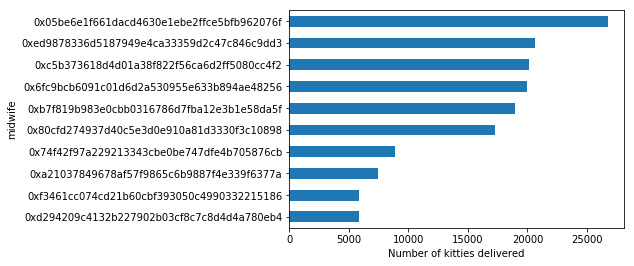

In [75]:
births_2018[births_2018['midwife'].isin(TopMidwives_2018)].groupby(['midwife']).data.count().sort_values().plot(kind='barh')
plt.xlabel('Number of kitties delivered')

Text(0.5,0,'Revenue (ETH)')

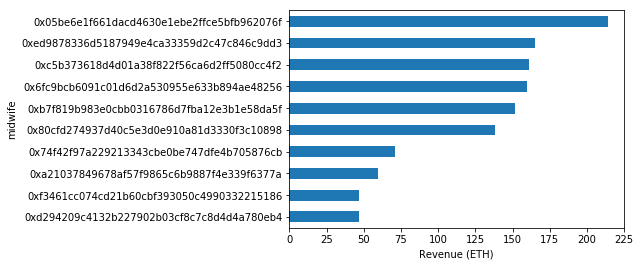

In [76]:
df_profitability[df_profitability['midwife'].isin(TopMidwives_2018)].groupby(['midwife']).revenue.sum().sort_values().plot(kind='barh')
plt.xlabel('Revenue (ETH)')

Text(0.5,0,'Profit (ETH)')

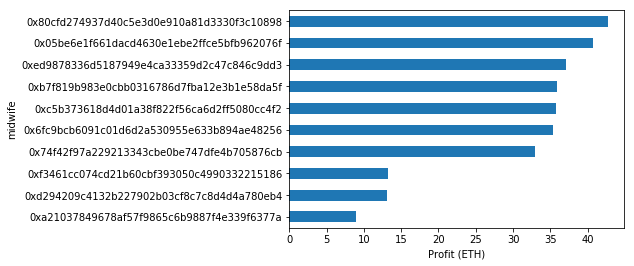

In [77]:
df_profitability[df_profitability['midwife'].isin(TopMidwives_2018)].groupby(['midwife']).profit.sum().sort_values().plot(kind='barh')
plt.xlabel('Profit (ETH)')

Text(0.5,0,'Profit (ETH)')

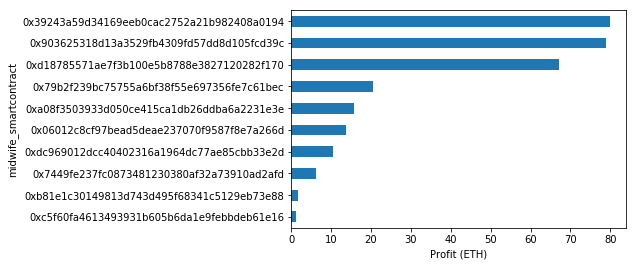

In [78]:
df_profitability[df_profitability['midwife'].isin(TopMidwives_2018)].groupby(['midwife_smartcontract']).profit.sum().sort_values().tail(10).plot(kind='barh')
plt.xlabel('Profit (ETH)')

Text(0.5,0,'Code efficiency')

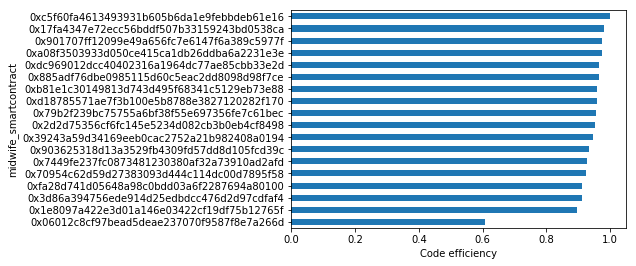

In [87]:
efficiency_plot = df_profitability[df_profitability['midwife'].isin(TopMidwives_2018)].groupby(['midwife_smartcontract']).code_efficiency.mean().sort_values()
efficiency_plot.divide(efficiency_plot.max(),axis=0).plot(kind='barh')
plt.xlabel('Code efficiency')

Text(0.5,0,'Efficiency')

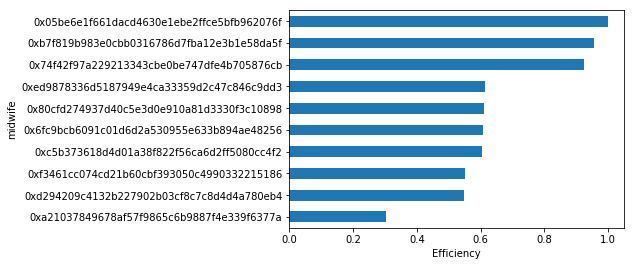

In [88]:
efficiency_plot = df_profitability[df_profitability['midwife'].isin(TopMidwives_2018)].groupby(['midwife']).efficiency.mean().sort_values()
efficiency_plot.divide(efficiency_plot.max(),axis=0).plot(kind='barh')
plt.xlabel('Efficiency')

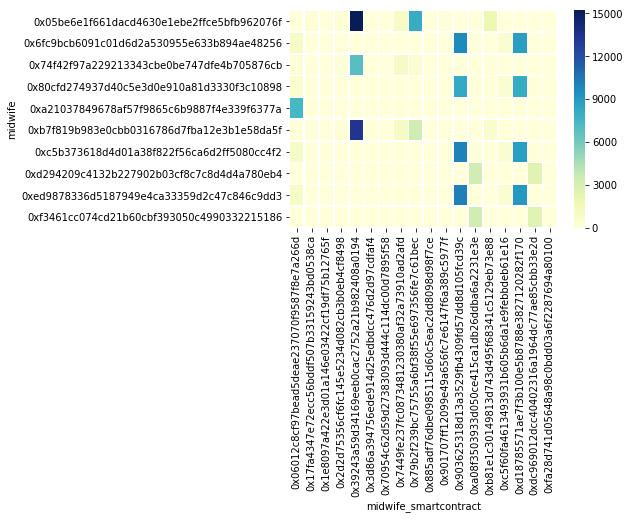

In [106]:
import seaborn as sns
heatmap = pd.DataFrame(births_2018[births_2018['midwife'].isin(TopMidwives_2018)].groupby(['midwife','midwife_smartcontract']).data.count()).reset_index().pivot(index='midwife', columns='midwife_smartcontract', values='data')
heatmap = heatmap.fillna(0)
sns.heatmap(heatmap, linewidths=.5, cmap="YlGnBu")

Text(0,0.5,'transaction count')

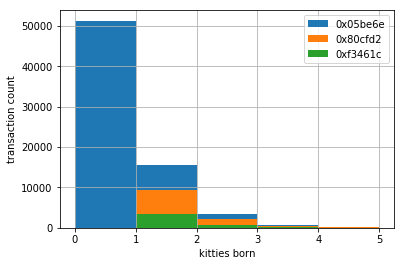

In [153]:
df_profitability[(df_profitability['midwife']=='0x05be6e1f661dacd4630e1ebe2ffce5bfb962076f')].kitties_delivered.hist(bins=[0,1,2,3,4,5], label='0x05be6e')
df_profitability[(df_profitability['midwife']=='0x80cfd274937d40c5e3d0e910a81d3330f3c10898')].kitties_delivered.hist(bins=[0,1,2,3,4,5], label='0x80cfd2')
df_profitability[(df_profitability['midwife']=='0xf3461cc074cd21b60cbf393050c4990332215186')].kitties_delivered.hist(bins=[0,1,2,3,4,5], label='0xf3461c')

plt.legend(loc='upper right')
plt.xlabel('kitties born')
plt.ylabel('transaction count')

In [132]:
df_profitability[(df_profitability['midwife']=='0x05be6e1f661dacd4630e1ebe2ffce5bfb962076f') & \
                 (df_profitability['kitties_delivered']==0) & \
                 (df_profitability['midwife_smartcontract']=='0x39243a59d34169eeb0cac2752a21b982408a0194') & \
                 (df_profitability['gasUsed']>55000)].profit.sum()

-11.000130717782001

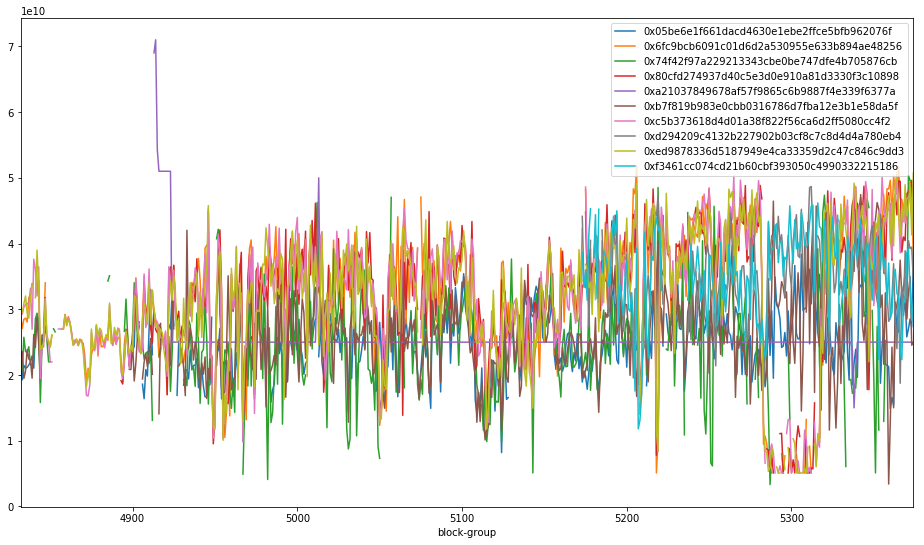

In [164]:
gaspriceplot = births_2018[births_2018['midwife'].isin(TopMidwives_2018)].groupby(['midwife', 'block-group']).gasPrice.mean().reset_index()
gaspriceplot = gaspriceplot.pivot('block-group', 'midwife', 'gasPrice')
gaspriceplot.plot(figsize=(16,9))
plt.legend(loc=1)